In [7]:
# ELECTRICAL ASSET INTELLIGENCE PLATFORM
# 03: Hyperparameter Tuning Notebook
# SPE AI/ML Boot Camp Final Project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, classification_report, confusion_matrix)
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Set style for consistent visualizations
# plt.style.use('seaborn-whitegrid')   # removed: causes FileNotFoundError on some setups
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")
# sns.set_palette("viridis")  # optional, redundant with set_theme palette

# Create results directory if it doesn't exist
if not os.path.exists('../results'):
    os.makedirs('../results')

In [8]:
# Load and preprocess data for classification
print("Loading electrical asset datasets for classification...")

def load_and_preprocess_classification_data(asset_type):
    """Load and preprocess data for health classification"""
    df = pd.read_csv(f'../data/{asset_type}_data.csv')
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    # Create time-based features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Calculate rolling features
    if asset_type == 'transformer':
        df['oil_temp_7d_avg'] = df['oil_temp_c'].rolling(window=7, min_periods=1).mean()
        df['winding_temp_7d_avg'] = df['winding_temp_c'].rolling(window=7, min_periods=1).mean()
        df['temp_diff'] = df['winding_temp_c'] - df['oil_temp_c']
        df['temp_diff_7d_avg'] = df['temp_diff'].rolling(window=7, min_periods=1).mean()
        
        # Calculate rate of change
        df['oil_temp_rate'] = df['oil_temp_c'].diff().fillna(0)
        df['winding_temp_rate'] = df['winding_temp_c'].diff().fillna(0)
    elif asset_type == 'motor':
        df['vibration_7d_avg'] = df['vibration_mm_s'].rolling(window=7, min_periods=1).mean()
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        
        # Calculate rate of change
        df['vibration_rate'] = df['vibration_mm_s'].diff().fillna(0)
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)
    elif asset_type == 'capacitor':
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        df['harmonic_7d_avg'] = df['harmonic_distortion_percent'].rolling(window=7, min_periods=1).mean()
        
        # Calculate rate of change
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)
        df['harmonic_rate'] = df['harmonic_distortion_percent'].diff().fillna(0)
    elif asset_type == 'ups':
        df['voltage_7d_avg'] = df['voltage_per_cell_v'].rolling(window=7, min_periods=1).mean()
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        
        # Calculate rate of change
        df['voltage_rate'] = df['voltage_per_cell_v'].diff().fillna(0)
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)
    
    # Drop the date column for modeling
    df = df.drop('date', axis=1)
    
    # Convert categorical features
    if asset_type == 'transformer':
        df = pd.get_dummies(df, columns=['oil_quality'], prefix='oil_quality')
    elif asset_type == 'motor':
        df = pd.get_dummies(df, columns=['bearing_condition'], prefix='bearing')
    elif asset_type == 'capacitor':
        df = pd.get_dummies(df, columns=['fuse_status'], prefix='fuse')
    elif asset_type == 'ups':
        df = pd.get_dummies(df, columns=['operating_mode'], prefix='mode')
    
    # Map health status to numeric values
    health_mapping = {'Healthy': 0, 'Warning': 1, 'Critical': 2}
    df['health_status_num'] = df['health_status'].map(health_mapping)
    
    # Define features and target
    X = df.drop(['health_status', 'health_status_num', 'failure_mode'], axis=1)
    y = df['health_status_num']
    
    return X, y, health_mapping

# Load all datasets
transformer_X, transformer_y, transformer_mapping = load_and_preprocess_classification_data('transformer')
motor_X, motor_y, motor_mapping = load_and_preprocess_classification_data('motor')
capacitor_X, capacitor_y, capacitor_mapping = load_and_preprocess_classification_data('capacitor')
ups_X, ups_y, ups_mapping = load_and_preprocess_classification_data('ups')


Loading electrical asset datasets for classification...


In [10]:
# 1. Baseline Random Forest Models
print("\nTraining baseline Random Forest models...")

def train_random_forest(X, y, random_state=42):
    """Train a baseline Random Forest classifier"""
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

def evaluate_model(model, X_test, y_test, class_names=None):
    """Evaluate a classification model"""
    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Build safe per-class report: only include labels present in y_test or y_pred
    labels_present = np.unique(np.concatenate([np.asarray(y_test), np.asarray(y_pred)])).tolist()
    labels_present = sorted([int(l) for l in labels_present])

    if class_names is not None:
        # class_names expected to be ordered list where index == label
        try:
            target_names = [class_names[i] for i in labels_present]
            class_report = classification_report(y_test, y_pred, labels=labels_present, target_names=target_names, zero_division=0)
        except Exception:
            # fallback to default behavior
            class_report = classification_report(y_test, y_pred, zero_division=0)
    else:
        class_report = classification_report(y_test, y_pred, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels_present)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

# Train and evaluate baseline models for all assets
baseline_results = {}
baseline_models = {}

for asset_type, (X, y, mapping) in zip(
    ['transformer', 'motor', 'capacitor', 'ups'],
    [(transformer_X, transformer_y, transformer_mapping), 
     (motor_X, motor_y, motor_mapping),
     (capacitor_X, capacitor_y, capacitor_mapping),
     (ups_X, ups_y, ups_mapping)]
):
    print(f"\nTraining baseline Random Forest for {asset_type}...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    model = train_random_forest(X_train, y_train)

    # Evaluate model
    # build ordered class_names from mapping dict (label -> name)
    if isinstance(mapping, dict):
        inv_map = {v: k for k, v in mapping.items()}
        class_names_ordered = [inv_map[i] for i in sorted(inv_map.keys())]
    else:
        class_names_ordered = None

    results = evaluate_model(model, X_test, y_test, class_names=class_names_ordered)
    baseline_results[asset_type] = results
    baseline_models[asset_type] = model

    # Save model
    if not os.path.exists('../models'):
        os.makedirs('../models')
    joblib.dump(model, f'../models/baseline_random_forest_{asset_type}.pkl')
    
    # Print results
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")



Training baseline Random Forest models...

Training baseline Random Forest for transformer...
Accuracy: 0.9950
F1 Score: 0.9925

Training baseline Random Forest for motor...
Accuracy: 0.9950
F1 Score: 0.9946

Training baseline Random Forest for capacitor...
Accuracy: 0.9900
F1 Score: 0.9896

Training baseline Random Forest for ups...
Accuracy: 0.9700
F1 Score: 0.9652


In [17]:
# 2. Hyperparameter Tuning with RandomizedSearchCV
print("\nPerforming hyperparameter tuning...")

from joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import os, joblib

def tune_random_forest(X_train, y_train, asset_type, n_iter=20):
    """Perform hyperparameter tuning for Random Forest classifier (Windows-safe)."""
    print(f"\n🔍 Performing hyperparameter tuning for {asset_type}...")

    # Dynamic CV folds based on dataset size
    if len(y_train) < 10:
        cv_folds = 2
    elif len(y_train) < 30:
        cv_folds = 3
    else:
        cv_folds = 5

    # Parameter search space
    param_dist = {
        'n_estimators': sp_randint(100, 300),
        'max_depth': sp_randint(5, 20),
        'min_samples_split': sp_randint(2, 10),
        'min_samples_leaf': sp_randint(1, 5),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # Base RF model
    rf = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=1   # keep safe to avoid nested parallelism issues
    )

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='f1_weighted',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit safely with threading backend on Windows
    try:
        with parallel_backend('threading', n_jobs=-1):
            random_search.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ Threading backend failed: {e} — fallback to single-process.")
        random_search.n_jobs = 1
        random_search.fit(X_train, y_train)

    # Best model
    best_rf = random_search.best_estimator_

    # Save best model
    os.makedirs('../models', exist_ok=True)
    joblib.dump(best_rf, f'../models/best_random_forest_{asset_type}.pkl')

    # Save results plot if available
    mean_scores = random_search.cv_results_.get('mean_test_score')
    if mean_scores is not None:
        os.makedirs('../results', exist_ok=True)
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(mean_scores)), mean_scores, 'o-')
        plt.title(f'RandomizedSearchCV Results - {asset_type.capitalize()}')
        plt.xlabel('Iteration')
        plt.ylabel('F1 Score (Weighted)')
        plt.grid(True)
        plt.savefig(f'../results/hyperparameter_tuning_{asset_type}.png', dpi=300, bbox_inches='tight')
        plt.close()

    # Print best config
    print(f"\n✅ Best parameters for {asset_type}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best F1 Score: {random_search.best_score_:.4f}")

    return best_rf, random_search.best_params_, random_search.best_score_


# ---- Run tuning for all assets ----
tuned_results, tuned_models, tuned_params = {}, {}, {}

for asset_type, (X, y, mapping) in zip(
    ['transformer', 'motor', 'capacitor', 'ups'],
    [(transformer_X, transformer_y, transformer_mapping), 
     (motor_X, motor_y, motor_mapping),
     (capacitor_X, capacitor_y, capacitor_mapping),
     (ups_X, ups_y, ups_mapping)]
):
    print(f"\n🚀 Tuning Random Forest for {asset_type}...")

    # Robust split with fallback (small class protection)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except Exception:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    # Tune
    model, params, best_score = tune_random_forest(X_train, y_train, asset_type)
    tuned_models[asset_type] = model
    tuned_params[asset_type] = params

    # Class names (reverse mapping if available)
    if isinstance(mapping, dict):
        inv_map = {v: k for k, v in mapping.items()}
        class_names_ordered = [inv_map[i] for i in sorted(inv_map.keys())]
    else:
        class_names_ordered = None

    # Evaluate
    results = evaluate_model(model, X_test, y_test, class_names=class_names_ordered)
    tuned_results[asset_type] = results

    print(f"Tuned Model Accuracy: {results['accuracy']:.4f}")
    print(f"Tuned Model F1 Score: {results['f1_score']:.4f}")



Performing hyperparameter tuning...

🚀 Tuning Random Forest for transformer...

🔍 Performing hyperparameter tuning for transformer...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



✅ Best parameters for transformer:
  bootstrap: True
  max_depth: 7
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 266
Best F1 Score: 0.9949
Tuned Model Accuracy: 0.9950
Tuned Model F1 Score: 0.9925

🚀 Tuning Random Forest for motor...

🔍 Performing hyperparameter tuning for motor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best parameters for motor:
  bootstrap: True
  max_depth: 9
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 4
  n_estimators: 174
Best F1 Score: 1.0000
Tuned Model Accuracy: 1.0000
Tuned Model F1 Score: 1.0000

🚀 Tuning Random Forest for capacitor...

🔍 Performing hyperparameter tuning for capacitor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best parameters for capacitor:
  bootstrap: True
  max_depth: 9
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 4
  n_estimators: 174
Best F1 Score: 0.9974
Tuned Model Accuracy: 1.0000
Tuned Model F1 Score: 1.0000

c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



✅ Best parameters for ups:
  bootstrap: True
  max_depth: 14
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 7
  n_estimators: 274
Best F1 Score: 0.9975
Tuned Model Accuracy: 1.0000
Tuned Model F1 Score: 1.0000



Analyzing feature importance...

Plotting feature importance for transformer...


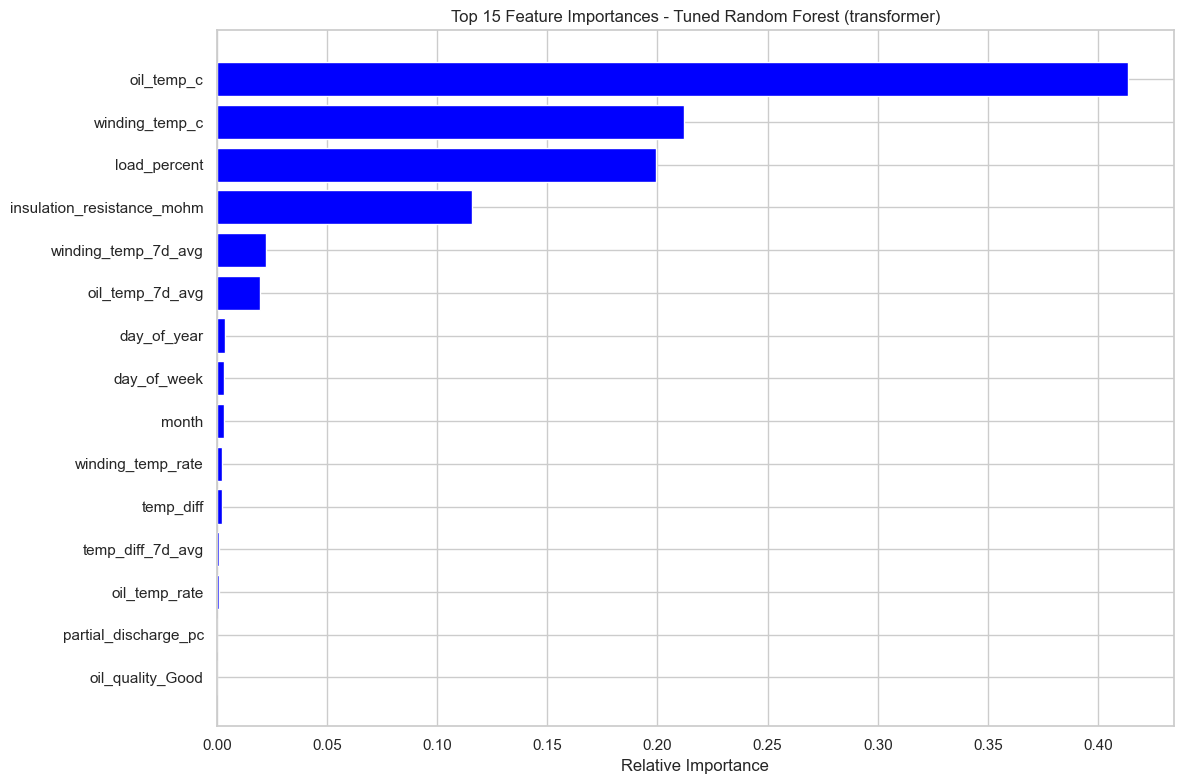


Plotting feature importance for motor...


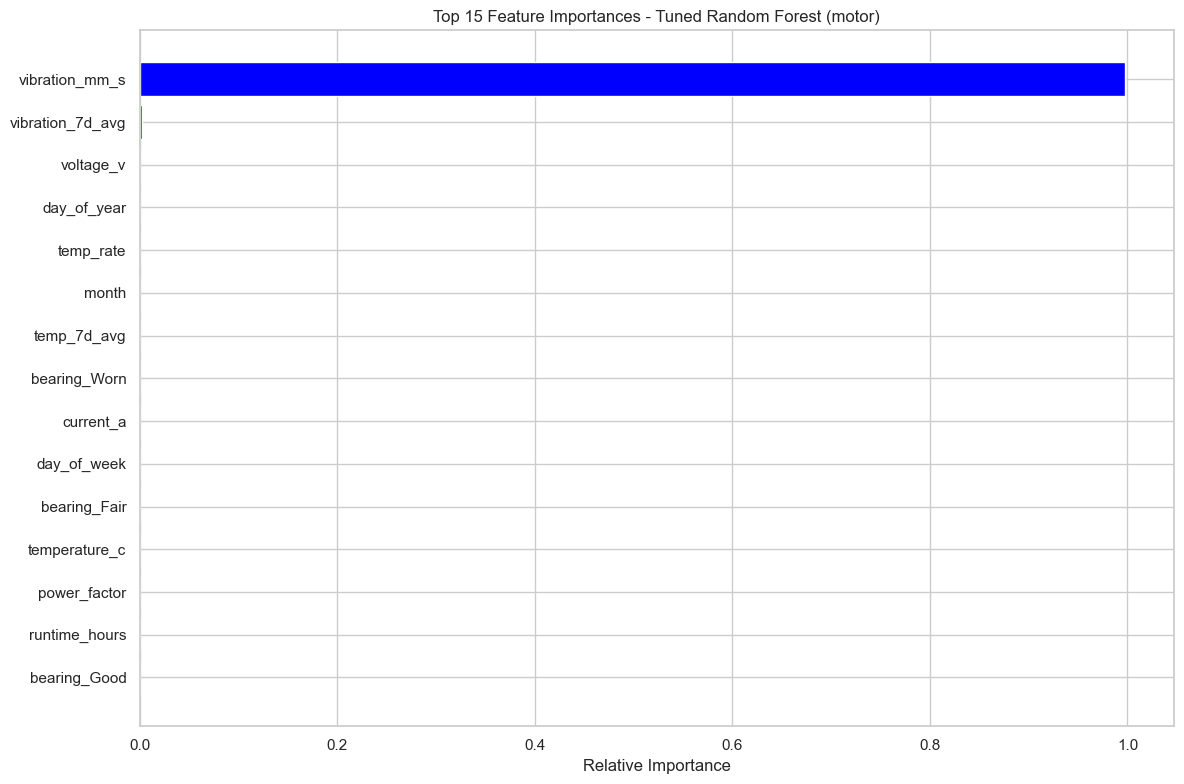


Plotting feature importance for capacitor...


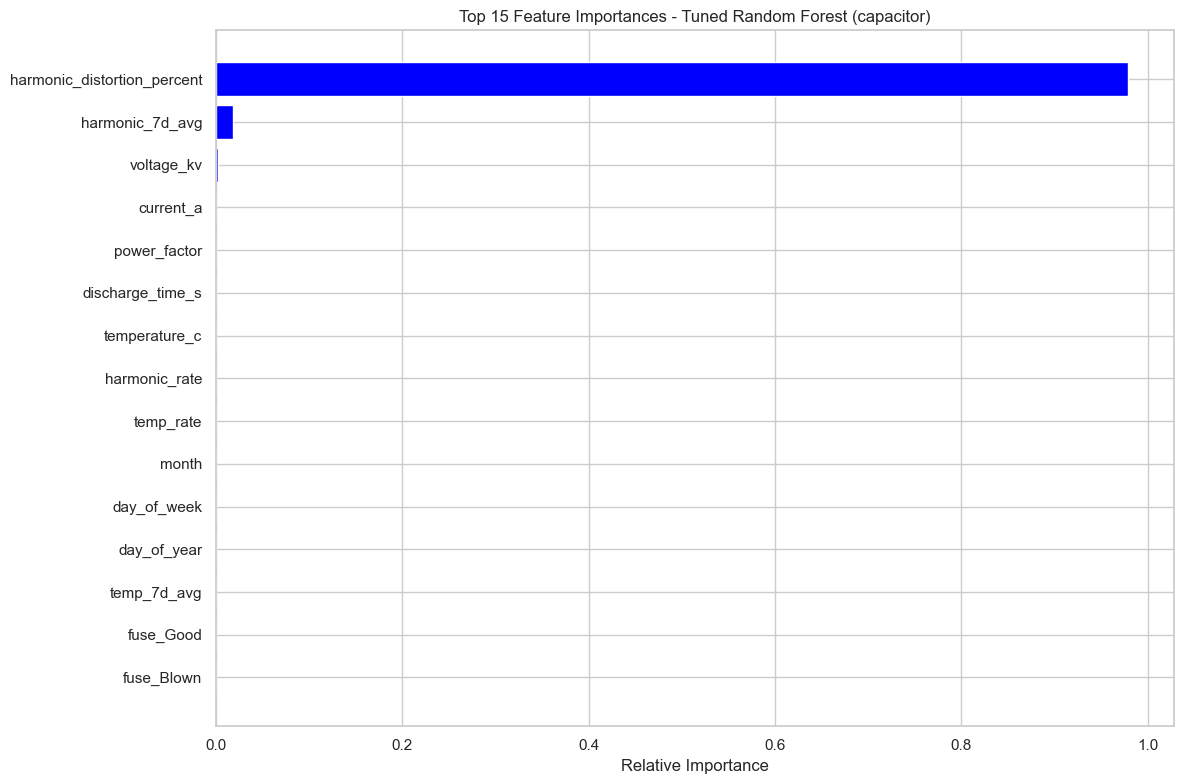


Plotting feature importance for ups...


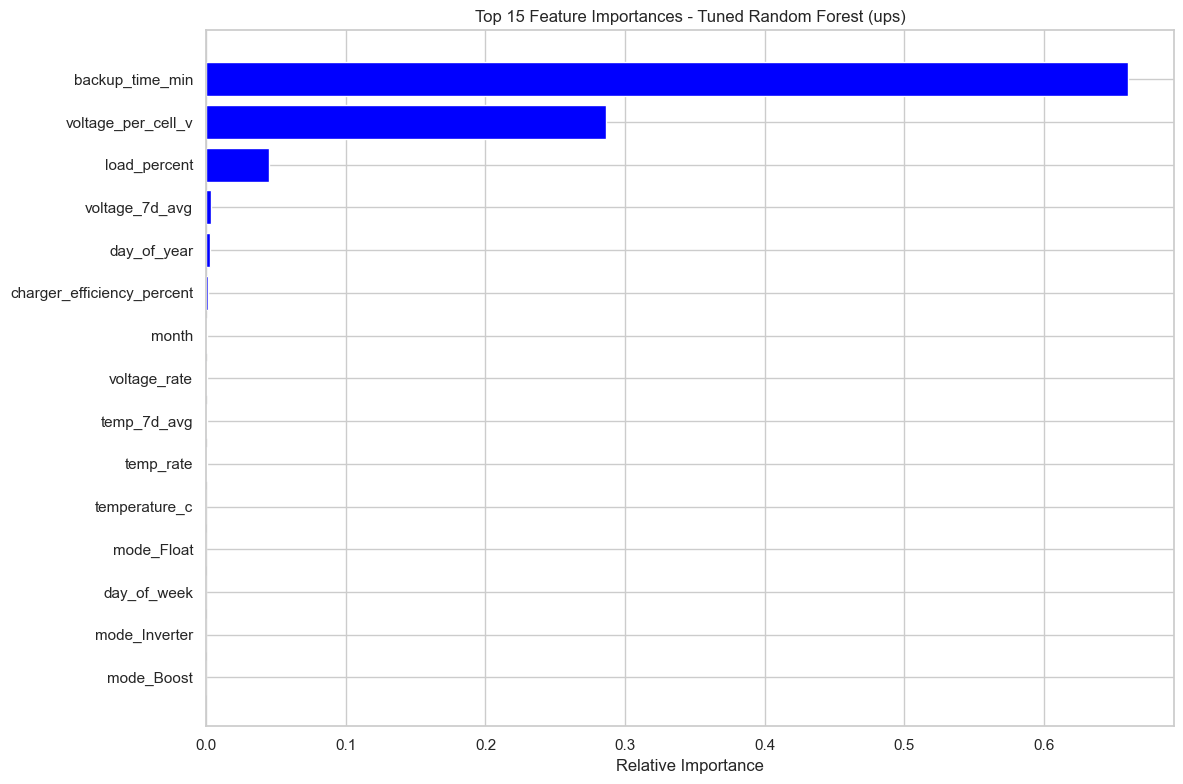

In [19]:
# 3. Feature Importance Analysis
print("\nAnalyzing feature importance...")

from IPython.display import display

def plot_feature_importance(model, feature_names, model_name, asset_type, top_n=15, show_plot=True):
    """Plot feature importance and show inline in Jupyter"""
    plt.figure(figsize=(12, 8))
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.title(f'Top {top_n} Feature Importances - {model_name} ({asset_type})')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    
    plt.tight_layout()
    
    # Save the plot
    os.makedirs('../results', exist_ok=True)
    plt.savefig(f'../results/feature_importance_{model_name.lower().replace(" ", "_")}_{asset_type}.png', 
                dpi=300, bbox_inches='tight')
    
    # Show inline
    if show_plot:
        plt.show()
    else:
        plt.close()

# Plot feature importance for all assets
for asset_type, model in tuned_models.items():
    print(f"\nPlotting feature importance for {asset_type}...")
    
    if asset_type == 'transformer':
        feature_names = transformer_X.columns.tolist()
    elif asset_type == 'motor':
        feature_names = motor_X.columns.tolist()
    elif asset_type == 'capacitor':
        feature_names = capacitor_X.columns.tolist()
    else:
        feature_names = ups_X.columns.tolist()
    
    plot_feature_importance(model, feature_names, "Tuned Random Forest", asset_type)


Comparing baseline and tuned models...


,Asset Type,Model,Accuracy,Precision,Recall,F1 Score
0,transformer,Baseline,0.995,0.990026,0.995,0.992506
1,transformer,Tuned,0.995,0.990026,0.995,0.992506
2,motor,Baseline,0.995,0.995027,0.995,0.994650
3,motor,Tuned,1.000,1.000000,1.000,1.000000
4,capacitor,Baseline,0.990,0.990026,0.990,0.989649
5,capacitor,Tuned,1.000,1.000000,1.000,1.000000
6,ups,Baseline,0.970,0.970928,0.970,0.965236
7,ups,Tuned,1.000,1.000000,1.000,1.000000


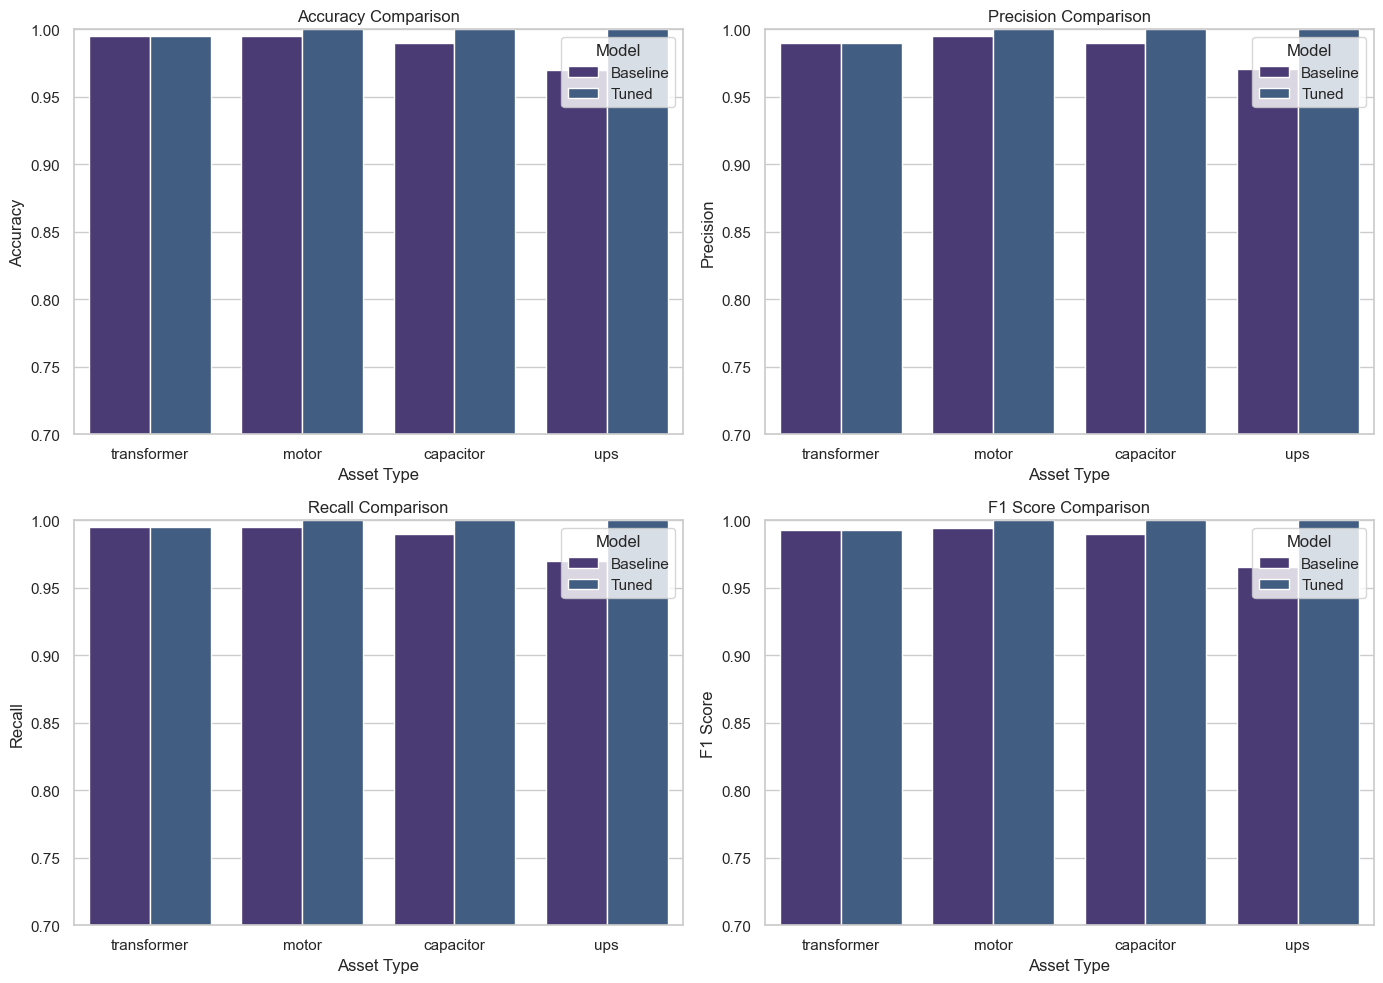

In [20]:
# 4. Model Comparison and Performance Analysis
print("\nComparing baseline and tuned models...")

comparison_data = []

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    baseline = baseline_results[asset_type]
    tuned = tuned_results[asset_type]
    
    comparison_data.append([
        asset_type, 'Baseline',
        baseline['accuracy'], baseline['precision'],
        baseline['recall'], baseline['f1_score']
    ])
    comparison_data.append([
        asset_type, 'Tuned',
        tuned['accuracy'], tuned['precision'],
        tuned['recall'], tuned['f1_score']
    ])

comparison_df = pd.DataFrame(comparison_data, columns=[
    'Asset Type', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'
])

# Show dataframe inline
display(comparison_df)

# Plot comparison
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Asset Type', y='Accuracy', hue='Model', data=comparison_df)
plt.title('Accuracy Comparison')
plt.ylim(0.7, 1.0)

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Asset Type', y='Precision', hue='Model', data=comparison_df)
plt.title('Precision Comparison')
plt.ylim(0.7, 1.0)

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Asset Type', y='Recall', hue='Model', data=comparison_df)
plt.title('Recall Comparison')
plt.ylim(0.7, 1.0)

# F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x='Asset Type', y='F1 Score', hue='Model', data=comparison_df)
plt.title('F1 Score Comparison')
plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

comparison_df.to_csv('../results/model_comparison.csv', index=False)


Generating confusion matrices...

Generating confusion matrices for transformer...


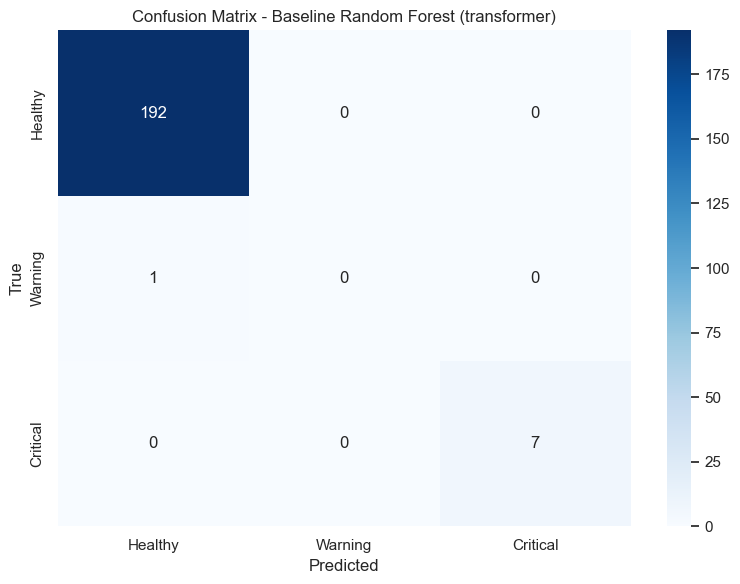

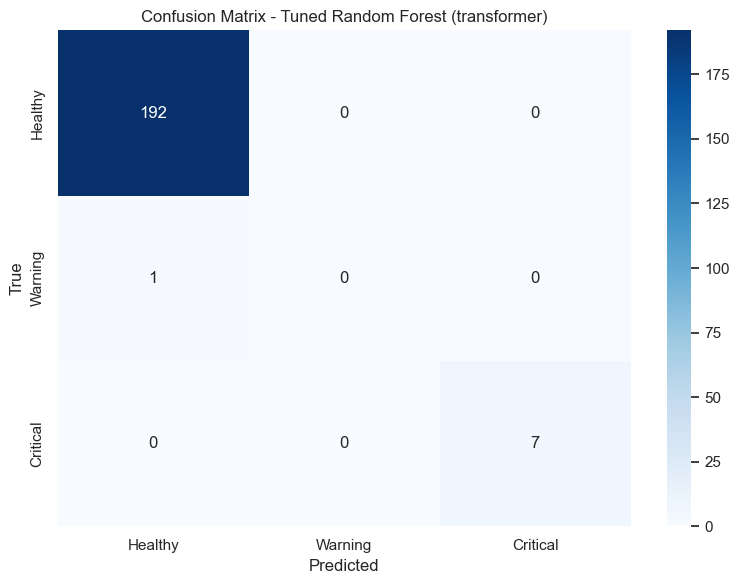


Generating confusion matrices for motor...


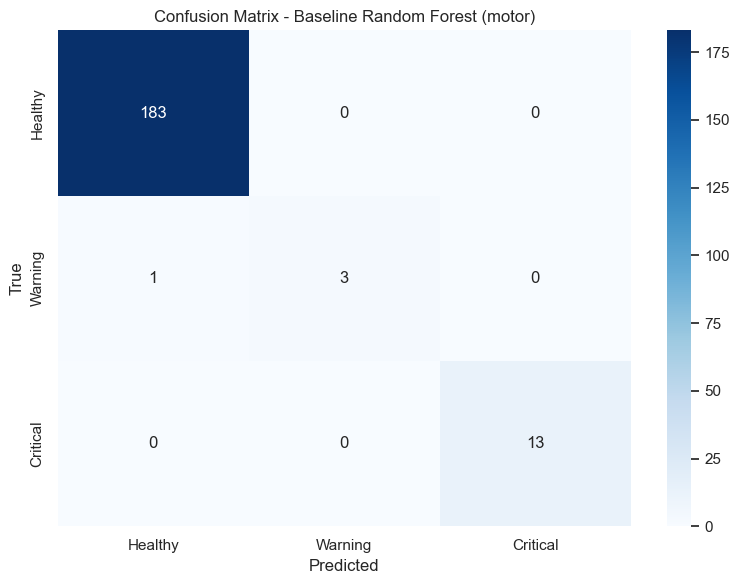

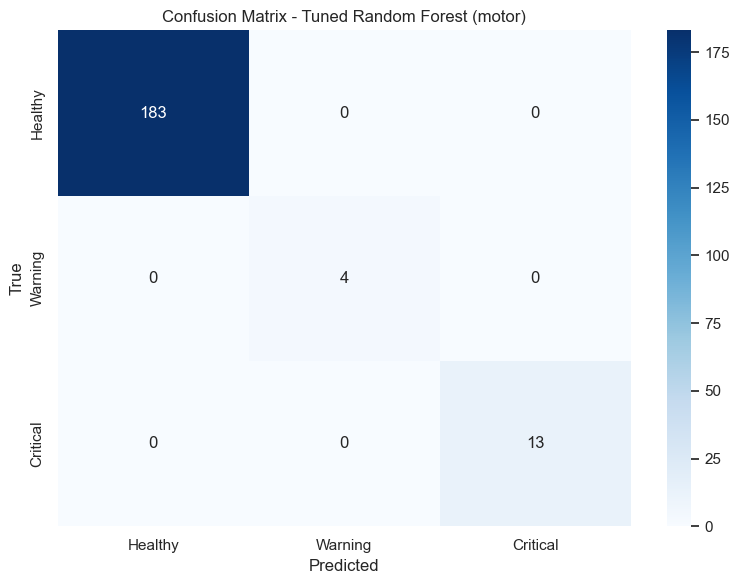


Generating confusion matrices for capacitor...


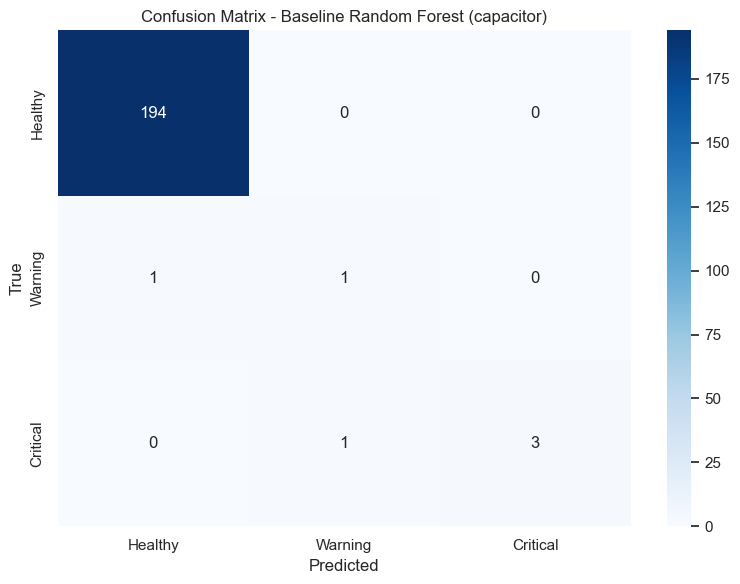

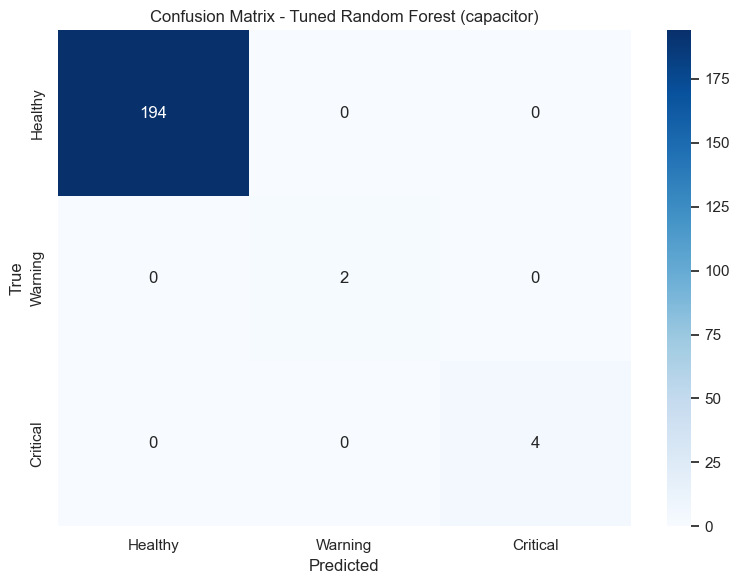


Generating confusion matrices for ups...


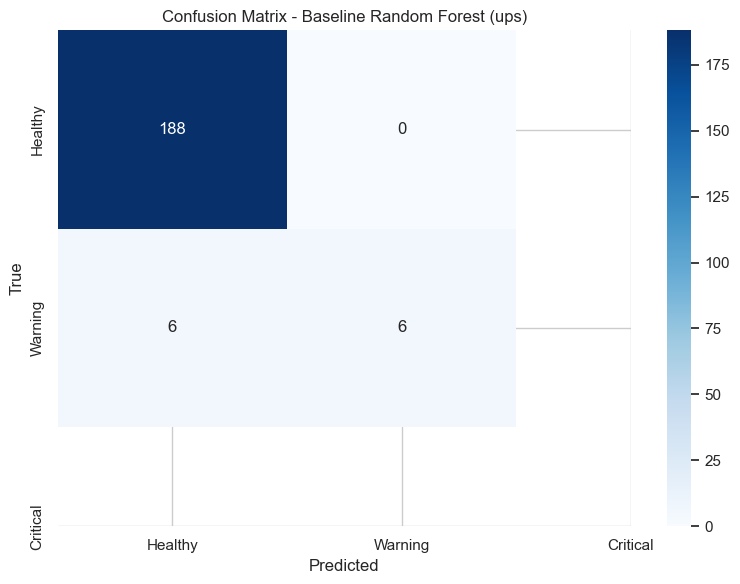

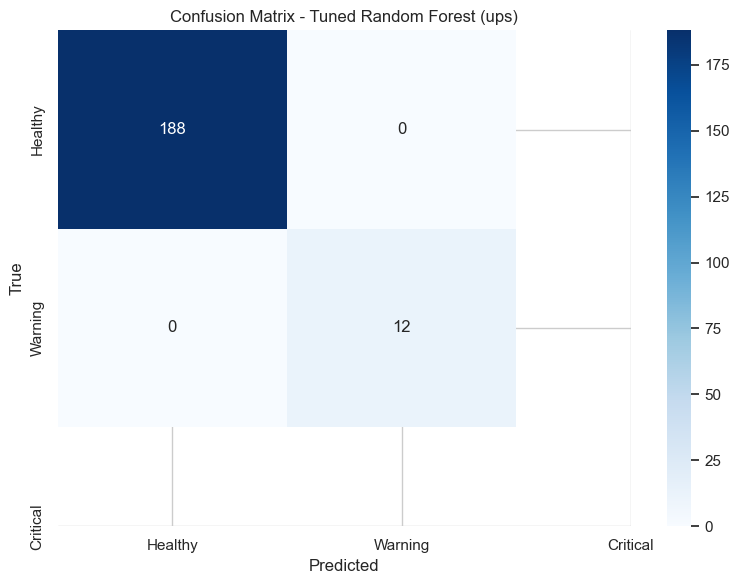

In [21]:
# 5. Confusion Matrix Visualization
print("\nGenerating confusion matrices...")

def plot_confusion_matrix(cm, class_names, model_name, asset_type, show_plot=True):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name} ({asset_type})')
    plt.tight_layout()
    
    os.makedirs('../results', exist_ok=True)
    plt.savefig(f'../results/confusion_matrix_{model_name.lower().replace(" ", "_")}_{asset_type}.png', 
                dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    print(f"\nGenerating confusion matrices for {asset_type}...")
    
    if asset_type == 'transformer':
        class_names = list(transformer_mapping.keys())
    elif asset_type == 'motor':
        class_names = list(motor_mapping.keys())
    elif asset_type == 'capacitor':
        class_names = list(capacitor_mapping.keys())
    else:
        class_names = list(ups_mapping.keys())
    
    # Baseline
    plot_confusion_matrix(baseline_results[asset_type]['confusion_matrix'], 
                          class_names, "Baseline Random Forest", asset_type)
    # Tuned
    plot_confusion_matrix(tuned_results[asset_type]['confusion_matrix'], 
                          class_names, "Tuned Random Forest", asset_type)


Analyzing hyperparameter impact...


,Asset Type,Hyperparameter,Value
0,transformer,bootstrap,True
1,transformer,max_depth,7
2,transformer,max_features,None
3,transformer,min_samples_leaf,1
4,transformer,min_samples_split,2
5,transformer,n_estimators,266
6,motor,bootstrap,True
7,motor,max_depth,9
8,motor,max_features,None
9,motor,min_samples_leaf,2


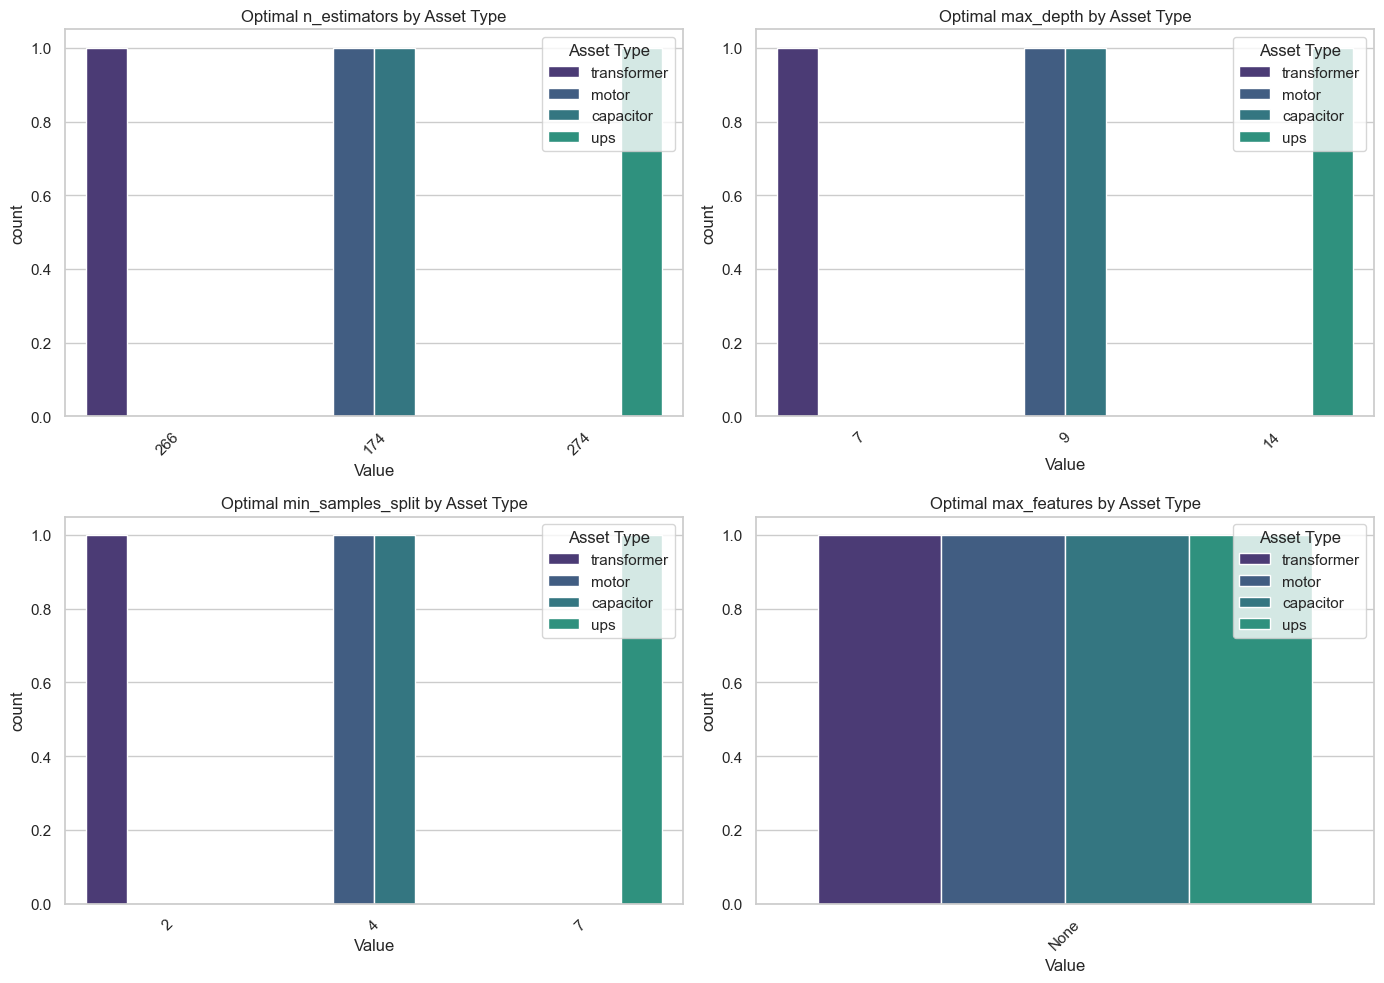


✅ Hyperparameter tuning completed! Visualizations are shown inline and saved in '../results'.


In [22]:
# 6. Hyperparameter Impact Analysis
print("\nAnalyzing hyperparameter impact...")

param_data = []
for asset_type, params in tuned_params.items():
    for param, value in params.items():
        param_data.append([asset_type, param, str(value)])

param_df = pd.DataFrame(param_data, columns=['Asset Type', 'Hyperparameter', 'Value'])

# Show dataframe inline
display(param_df)

plt.figure(figsize=(14, 10))

# n_estimators
plt.subplot(2, 2, 1)
sns.countplot(x='Value', hue='Asset Type', 
              data=param_df[param_df['Hyperparameter'] == 'n_estimators'])
plt.title('Optimal n_estimators by Asset Type')
plt.xticks(rotation=45)

# max_depth
plt.subplot(2, 2, 2)
sns.countplot(x='Value', hue='Asset Type', 
              data=param_df[param_df['Hyperparameter'] == 'max_depth'])
plt.title('Optimal max_depth by Asset Type')
plt.xticks(rotation=45)

# min_samples_split
plt.subplot(2, 2, 3)
sns.countplot(x='Value', hue='Asset Type', 
              data=param_df[param_df['Hyperparameter'] == 'min_samples_split'])
plt.title('Optimal min_samples_split by Asset Type')
plt.xticks(rotation=45)

# max_features
plt.subplot(2, 2, 4)
sns.countplot(x='Value', hue='Asset Type', 
              data=param_df[param_df['Hyperparameter'] == 'max_features'])
plt.title('Optimal max_features by Asset Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../results/hyperparameter_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Hyperparameter tuning completed! Visualizations are shown inline and saved in '../results'.")